In [60]:
import numpy as np
import pandas as pd

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import regularizers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mia.jensen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mia.jensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Collection

In [40]:
df = pd.read_csv("../../Datasets/sentiment_analysis/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df = df.drop(columns=["id"])
display(df.head(3))  

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."


### Data Preprocessing - Cleaning, Lematisation, Stemming, Stopwords

In [ ]:
# clean text 
#  - remove HTML tags
#  - remove special characters
#  - convert to lowercase

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

In [ ]:
# lemmatise words (reduce words to base forms)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['lemmatized_review'] = df['cleaned_review'].apply(lemmatize_text)

In [44]:
# remove stop words

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['final_review'] = df['lemmatized_review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mia.jensen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Data train test split

X = df["final_review"].to_numpy()
y = df["sentiment"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (17500,)
Training Data Output Shape:  (17500,)
Testing Data Input Shape:  (7500,)
Testing Data Output Shape:  (7500,)


In [47]:
# tokenise text corpus

vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

print("Number of Documents: ", tokenizer.document_count)
print("Number of Words: ", tokenizer.num_words)

Number of Documents:  17500
Number of Words:  10000


In [48]:
# convert reviews into number sequences, with padding
# Sequences greater than seq_length will be truncated. Sequences less than seq_length will be padded with zeros.

seq_length = 200

train_seqs = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seqs, maxlen=seq_length, padding='post', truncating='post')

test_seqs = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seqs, maxlen=seq_length, padding='post', truncating='post')

### Model - Build, Train, Evaluate

In [61]:
# build model

model = Sequential()

embedding_dim = 64  # Increased from 16
model.add(Embedding(vocab_size, embedding_dim, input_length=seq_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           640000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 128)         66048     
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 200, 128)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                      

In [62]:
# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(learning_rate=0.005),
    metrics=['accuracy']
)

In [ ]:
# train model

# adjust learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(
    train_padded, y_train, 
    epochs=30, 
    validation_data=(test_padded, y_test), 
    callbacks=[EarlyStopping(patience=5)] #, reduce_lr
)

Epoch 1/30
547/547 [==============================] - 323s 575ms/step - loss: 0.7284 - accuracy: 0.5075 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 2/30
547/547 [==============================] - 304s 555ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 3/30
547/547 [==============================] - 294s 538ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 4/30
547/547 [==============================] - 293s 535ms/step - loss: 0.6933 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 5/30
547/547 [==============================] - 285s 521ms/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 6/30
476/547 [=========================>....] - ETA: 34s - loss: 0.6933 - accuracy: 0.5007

KeyboardInterrupt: 

,loss,accuracy,val_loss,val_accuracy
0,0.586758,0.663143,0.414377,0.827733
1,0.345501,0.859943,0.391226,0.842400
2,0.247342,0.909086,0.359679,0.856533
3,0.188935,0.932743,0.391798,0.858533
4,0.157355,0.945143,0.417304,0.854000
5,0.122038,0.958286,0.472607,0.850533
6,0.092429,0.970229,0.469186,0.823067
7,0.087893,0.969829,0.558623,0.846800


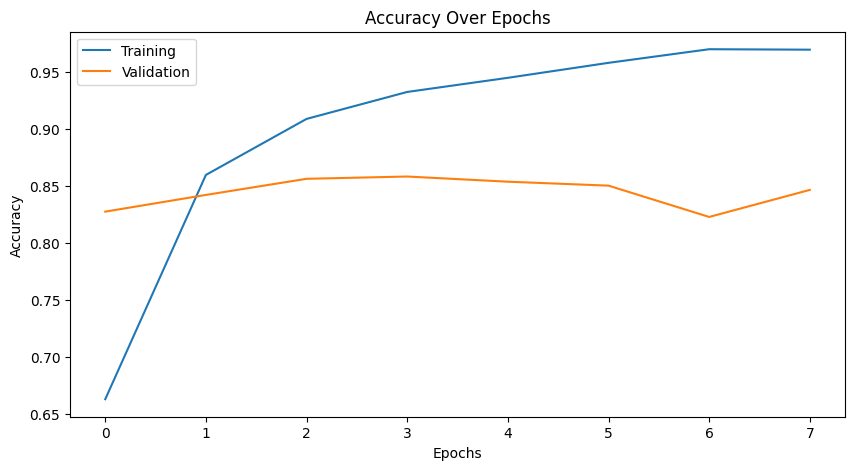

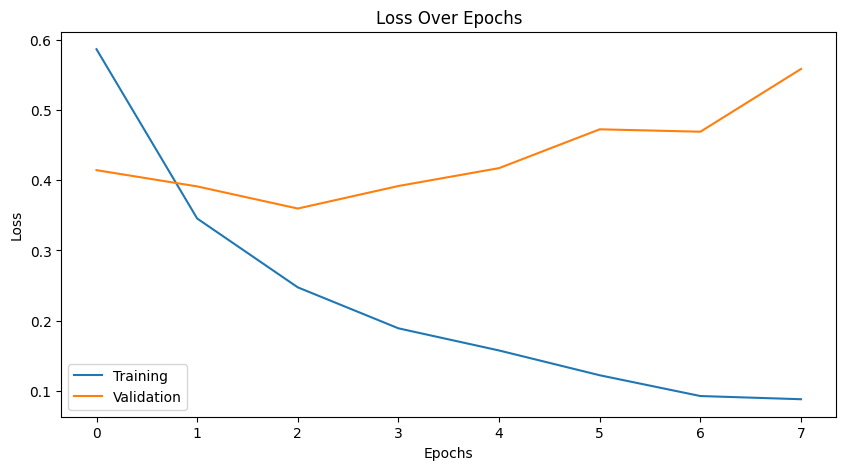

In [ ]:
df_metrics = pd.DataFrame(history.history)
display(df_metrics)

plt.figure(figsize=(10,5))
plt.plot(df_metrics.index, df_metrics.accuracy)
plt.plot(df_metrics.index, df_metrics.val_accuracy)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df_metrics.index, df_metrics.loss)
plt.plot(df_metrics.index, df_metrics.val_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()